# Total Return CAPE Ratio

### Prof. Shiller addressed the criticism of traditional CAPE ratio, that changes in corporate payout policy, such as share repurchases instead of dividends as dominant approach in the USA for cash distribution to shareholders, which can affect the growth rate and the average of the real earnings per share used in the CAPE ratio, by develping a Total Return CAPE, which corrects this bias by reinvesting dividents into the price index and properly scaling earnings per share.

### Total Return EPS tells us what earnings would have been if the dividend payout ratio had been 0% at all times. This way, it reduces all earnings data across all periods of history to the same common basis, allowing for accurate comparisons between any two points in time.

 ### Total Return CAPE is used as a valuation metric to forecast future returns, where a higher CAPE ratio could reflect lower returns over the next couple of decades, whereas a lower CAPE ratio could reflect higher returns over the next couple of decades, as the ratio reverts back to the mean.

Source:

[Online Data Robert Shiller](http://www.econ.yale.edu/~shiller/data.htm)
 
[A New-and-Improved Shiller CAPE: Solving the Dividend Payout Ratio Problem](http://www.philosophicaleconomics.com/2015/03/payout/)

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in TR_CAPE and S&P 500 data from Online Data Robert Shiller, drop nans, convert Date to str, edit Date column, 
# Convert to datetime, set date as index, edit column names, use data from 1900-2020
tr_cape = pd.read_excel('resources/TR_Cape.xlsx').dropna()
tr_cape['Date'] = tr_cape['Date'].astype('string')
tr_cape['Date'] = tr_cape['Date'].str.replace('.','-', regex=False)
tr_cape['Date'] = pd.to_datetime(tr_cape['Date'])
tr_cape = tr_cape.rename(columns= {'P':'S&P500', 'TR CAPE':'TR_CAPE'})
tr_cape = tr_cape.set_index('Date')
tr_cape = tr_cape['1900':]
tr_cape

,S&P500,TR_CAPE
Date,,
1900-01-01,6.100000,22.587335
1900-02-01,6.210000,22.595749
1900-03-01,6.260000,22.658552
1900-04-01,6.340000,22.830123
1900-05-01,6.040000,22.172116
...,...,...
2021-12-01,4674.772727,41.717266
2022-01-01,4573.815500,40.149690
2022-02-01,4435.980526,38.518530


In [3]:
# Calculate TR CAPE stats
stats = tr_cape['TR_CAPE'].describe()
stats

count    1468.000000
mean       20.616624
std         7.839605
min         6.582425
25%        14.804845
50%        19.821594
75%        25.154250
max        48.110969
Name: TR_CAPE, dtype: float64

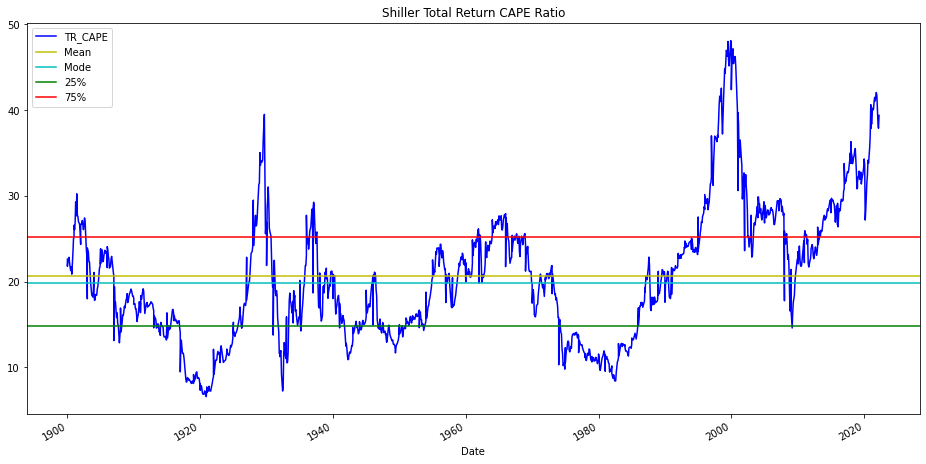

In [4]:
# Plot TR CAPE mean, mode, 25% and 75% values over selected time frame
tr_cape['TR_CAPE'].plot(figsize=(16,8), title='Shiller Total Return CAPE Ratio', legend=True, c='b')
plt.axhline(stats['mean'], c='y', label='Mean')
plt.axhline(stats['50%'], label='Mode', c='c')
plt.axhline(stats['25%'], label='25%', c='g')
plt.axhline(stats['75%'], label='75%', c='r')
plt.legend()